<a href="https://colab.research.google.com/github/Ak-Gautam/qdora_exp/blob/main/LoRa_vs_DoRa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install -q "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -q --no-deps xformers trl peft accelerate bitsandbytes datasets

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-43_sdpya/unsloth_db7f1e1ee8744c4abe2cfbaf321a1c2d
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-43_sdpya/unsloth_db7f1e1ee8744c4abe2cfbaf321a1c2d
  Resolved https://github.com/unslothai/unsloth.git to commit 64bb8cfd512a9dcd860d21563b624676f7432ec5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00


In [4]:
from unsloth import FastLanguageModel
import torch


model_name = "Qwen/Qwen2-1.5B"
max_seq_length = 512 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,

)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Qwen2 patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Qwen/Qwen2-1.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.


In [5]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments
)

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized

    use_gradient_checkpointing = "unsloth",
    random_state = 42,
    use_dora=True,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.6 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [7]:
dataset = load_dataset("timdettmers/openassistant-guanaco")


#Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, add_eos_token=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left' #Necessary for FlashAttention compatibility

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/9846 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/518 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
from trl import SFTTrainer, SFTConfig
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported


training_arguments = SFTConfig(
        output_dir="qdora",
        evaluation_strategy="steps",
        do_eval=True,
        optim="adamw_8bit",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps = 5,
        max_steps=200,
        log_level="debug",
        logging_steps=1,
        learning_rate=1e-5,
        eval_steps=50,
        # num_train_epochs=1,
        fp16= not torch.cuda.is_bf16_supported(),
        bf16= torch.cuda.is_bf16_supported(),
        save_strategy='epoch',
        weight_decay = 0.01,
        warmup_ratio=0.1,
        lr_scheduler_type="linear",
)

trainer = SFTTrainer(
        model=model,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        dataset_num_proc = 2,
        packing = False, # Can make training 5x faster for short sequences.
        tokenizer=tokenizer,
        args=training_arguments,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() w

Map (num_proc=2):   0%|          | 0/9846 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/518 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:397: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend


In [9]:
trainer_stats = trainer.train()

Currently training with a batch size of: 4
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 9,846 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 1
\        /    Total batch size = 4 | Total steps = 200
 "-____-"     Number of trainable parameters = 19,109,888


Step,Training Loss,Validation Loss
50,2.226900,1.725565
100,2.596100,1.694595
150,1.781300,1.673834
200,1.260700,1.668129


***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
***** Running Evaluation *****
  Num examples = 518
  Batch size = 4
Saving model checkpoint to qdora/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B/snapshots/8a16abf2848eda07cc5253dec660bf1ce007ad7a/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 131072,
  "max_window_layers": 28,
  "model_type": "qwen2",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_theta": 1000000.0,
  "sliding_window": 

In [12]:
loss_values = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]
# loss_values

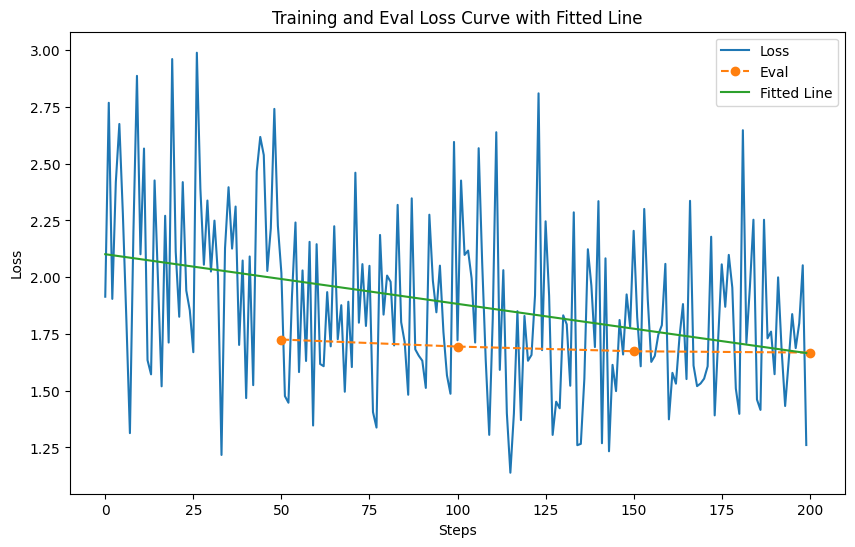

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming eval_losses contains the four values at steps 50, 100, 150, and 200
eval_steps = [50, 100, 150, 200]

# Fit a straight line to the loss curve
coefficients = np.polyfit(range(len(loss_values)), loss_values, 1)
slope, intercept = coefficients

# Generate the y values for the straight line
straight_line_values = [slope * x + intercept for x in range(len(loss_values))]

# Plot the loss curve, eval losses, and the straight line
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_values)), loss_values, label='Loss')
plt.plot(eval_steps, eval_losses, marker='o', linestyle='--', label='Eval')
plt.plot(range(len(loss_values)), straight_line_values, label='Fitted Line')
plt.title('Training and Eval Loss Curve with Fitted Line')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

compute_dtype = torch.float16
attn_implementation = 'sdpa'


adapter = "./qdora/checkpoint-200"
#Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_size="left",  use_fast=True)


model = AutoModelForCausalLM.from_pretrained(
          model_name, device_map={"": 0}, torch_dtype=compute_dtype,  attn_implementation=attn_implementation
)

model = PeftModel.from_pretrained(model, adapter)
model = model.merge_and_unload()

print(f"Successfully loaded the model {model_name} into memory")
#pushed to the hub
#model.push_to_hub("glouriousgautam/Mistral7B-v0.3-oasstguanaco-qdora-merged")
#tokenizer.push_to_hub("glouriousgautam/Mistral7B-v0.3-oasstguanaco-qdora-merged")


loading file vocab.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B/snapshots/8a16abf2848eda07cc5253dec660bf1ce007ad7a/vocab.json
loading file merges.txt from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B/snapshots/8a16abf2848eda07cc5253dec660bf1ce007ad7a/merges.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B/snapshots/8a16abf2848eda07cc5253dec660bf1ce007ad7a/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B/snapshots/8a16abf2848eda07cc5253dec660bf1ce007ad7a/tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Qwen--Qwen2-1.5B/snapshots/8a16abf2848ed

Successfully loaded the model Qwen/Qwen2-1.5B into memory


In [19]:
!pip install huggingface_hub

In [21]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [22]:
#pushed to the hub
model.push_to_hub("glouriousgautam/Qwen2-1.5b-oasstguanaco-qdora-merged")
tokenizer.push_to_hub("glouriousgautam/Qwen2-1.5b-oasstguanaco-qdora-merged")

Configuration saved in /tmp/tmprajyvdn3/config.json
Configuration saved in /tmp/tmprajyvdn3/generation_config.json
The model is bigger than the maximum size per checkpoint (5GB) and is going to be split in 2 checkpoint shards. You can find where each parameters has been saved in the index located at /tmp/tmprajyvdn3/model.safetensors.index.json.
Uploading the following files to glouriousgautam/Qwen2-1.5b-oasstguanaco-qdora-merged: generation_config.json,model.safetensors.index.json,model-00002-of-00002.safetensors,model-00001-of-00002.safetensors,README.md,config.json


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/727M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer config file saved in /tmp/tmp5fmp70pp/tokenizer_config.json
Special tokens file saved in /tmp/tmp5fmp70pp/special_tokens_map.json
Uploading the following files to glouriousgautam/Qwen2-1.5b-oasstguanaco-qdora-merged: tokenizer.json,merges.txt,special_tokens_map.json,added_tokens.json,README.md,vocab.json,tokenizer_config.json


CommitInfo(commit_url='https://huggingface.co/glouriousgautam/Qwen2-1.5b-oasstguanaco-qdora-merged/commit/63cabe23d2bdc26d57a0316a44eefc02907a5fe5', commit_message='Upload tokenizer', commit_description='', oid='63cabe23d2bdc26d57a0316a44eefc02907a5fe5', pr_url=None, pr_revision=None, pr_num=None)